In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Crime_Data_from_2020_to_Present.csv', encoding='unicode_escape')

In [3]:
(data.isnull().sum()/data.shape[0]) * 100

DR_NO              0.000000
Date Rptd          0.000000
DATE OCC           0.000000
TIME OCC           0.000000
AREA               0.000000
AREA NAME          0.000000
Rpt Dist No        0.000000
Part 1-2           0.000000
Crm Cd             0.000000
Crm Cd Desc        0.000000
Mocodes           13.780581
Vict Age           0.000000
Vict Sex          13.110681
Vict Descent      13.111677
Premis Cd          0.001121
Premis Desc        0.059156
Weapon Used Cd    65.188005
Weapon Desc       65.188005
Status             0.000000
Status Desc        0.000000
Crm Cd 1           0.001245
Crm Cd 2          92.633843
Crm Cd 3          99.754657
Crm Cd 4          99.992901
LOCATION           0.000000
Cross Street      83.993893
LAT                0.000000
LON                0.000000
dtype: float64

In [4]:
data.columns = data.columns.str.lower()

In [5]:
data.columns

Index(['dr_no', 'date rptd', 'date occ', 'time occ', 'area', 'area name',
       'rpt dist no', 'part 1-2', 'crm cd', 'crm cd desc', 'mocodes',
       'vict age', 'vict sex', 'vict descent', 'premis cd', 'premis desc',
       'weapon used cd', 'weapon desc', 'status', 'status desc', 'crm cd 1',
       'crm cd 2', 'crm cd 3', 'crm cd 4', 'location', 'cross street', 'lat',
       'lon'],
      dtype='object')

# first fix the gender column, replacing the null values with unknown


In [6]:
mapping = {'F':'2', 'M':'3', 'X':'0','H':'1', '-':'1'}

data['vict sex'] = data['vict sex'].map(mapping).fillna('1').astype('int')

<AxesSubplot: >

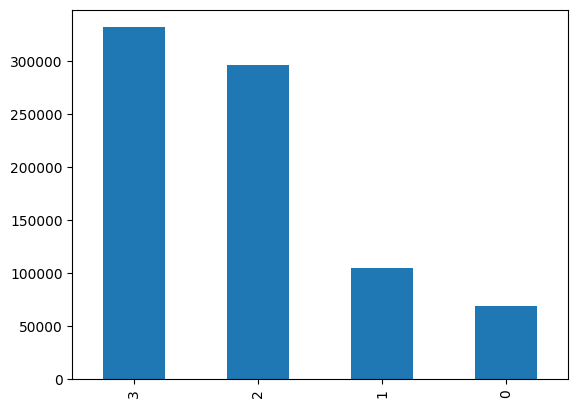

In [7]:
data['vict sex'].value_counts().plot(kind = 'bar')

# working on the Victim's Decent

In [8]:
data['modified_descent'] = data['vict descent'].replace(['K', 'F', 'C', 'J', 'V', 'I', 'Z'], 'A')
data['modified_descent'] = data['modified_descent'].apply(lambda x: 'P' if x in ['P', 'U', 'D', 'G', 'L', 'S'] else x)
data['modified_descent'] = data['modified_descent'].replace('-', 'U').fillna('U')
data['modified_descent'] = data['modified_descent'].apply(lambda x: 'O' if x in 'X,O,A,P,Pacific Islander'.split(',') else x)


<AxesSubplot: >

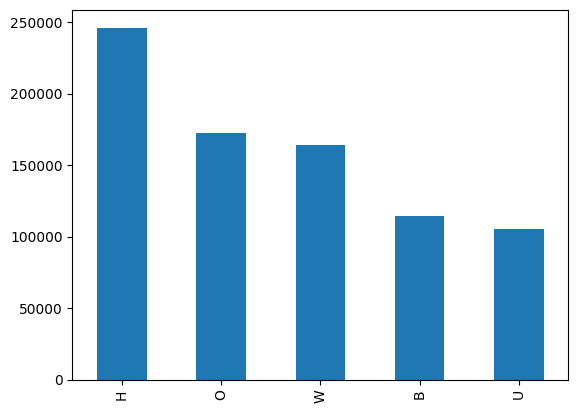

In [9]:
data['modified_descent'].value_counts().plot(kind = 'bar')

In [10]:
# encoding it to numerical features
descent_mapping = {'U': 0, 'B': 1, 'W':2, 'O':3, 'H': 4}
data.modified_descent = data.modified_descent.map(descent_mapping).astype('int')

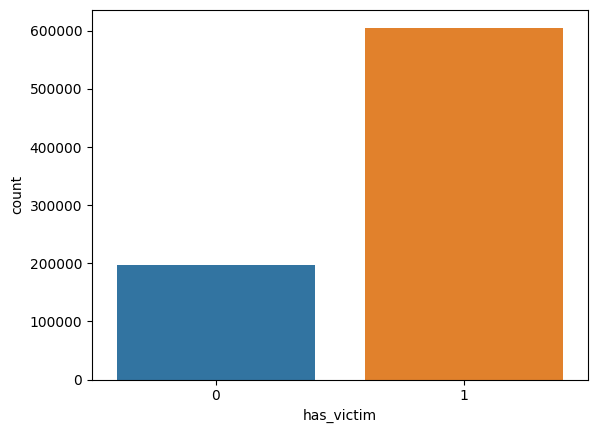

In [11]:
data['has_victim'] = data['vict age'].apply(lambda x: 1 if x > 0 else 0)

sns.countplot(data = data, x = 'has_victim')
plt.show()

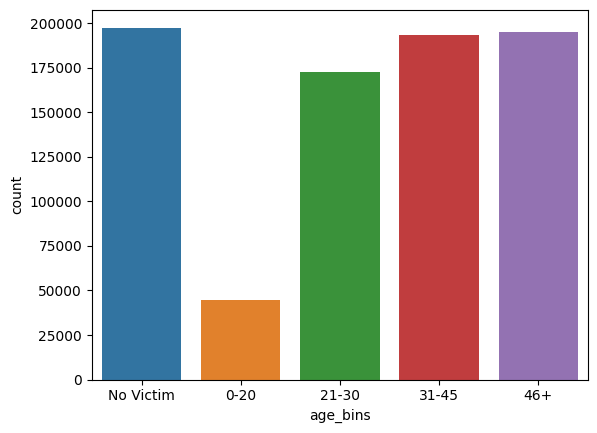

In [12]:
bin_edges = [-float('inf'), 0, 20, 31, 45, float('inf')]

# Define bin labels
bin_labels = ['No Victim', '0-20', '21-30', '31-45', '46+']

# Create a new column 'age_bins'
data['age_bins'] = pd.cut(data['vict age'], bins=bin_edges, labels=bin_labels)

# plotting the age_bins
sns.countplot(data = data, x = 'age_bins')
plt.show()

In [13]:
age_mapping = {'No Victim':0, '0-20':1, '21-30':2, '31-45':3, '46+':4}
data.age_bins = data.age_bins.map(age_mapping).astype('int')

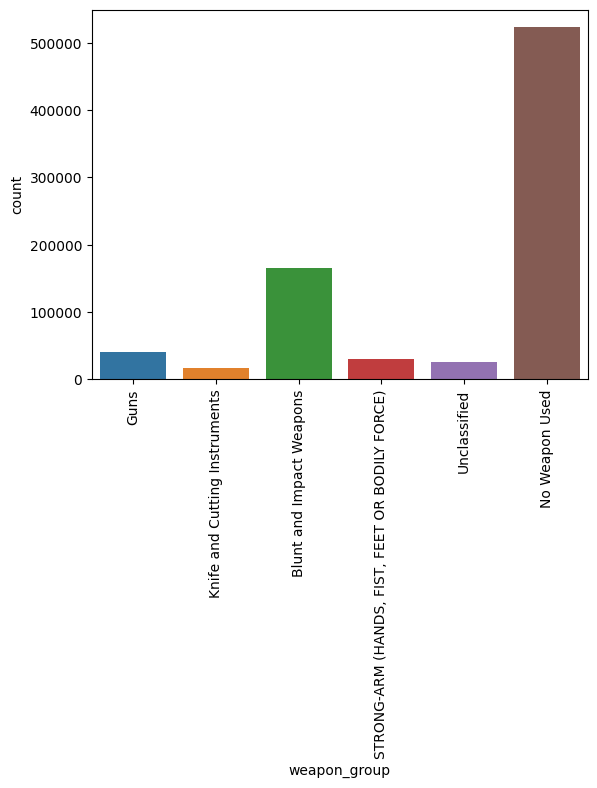

In [14]:
# Assuming data is your DataFrame and 'weapon used cd' is the column containing weapon codes
data['weapon_group'] = pd.cut(data['weapon used cd'],
                              bins=[100, 200, 300, 400, 500, float('inf')],
                              labels=['Guns', 'Knife and Cutting Instruments', 'Blunt and Impact Weapons',
                                      'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', 'Unclassified'])

data['weapon_group'] = data['weapon_group'].cat.add_categories('No Weapon Used').fillna('No Weapon Used')

# Plotting the age_bins
sns.countplot(data=data, x='weapon_group')
plt.xticks(rotation=90)
plt.show()


In [15]:
# mapping the weapons column to have integer values
weapon_mapping = {
    'Guns':100, 'Knife and Cutting Instruments':200, 'Blunt and Impact Weapons': 300,
                                      'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)':400, 'Unclassified':500, 'No Weapon Used':0
}
data['weapon_group'] = data['weapon_group'].map(weapon_mapping).astype('int')

In [16]:
data['location'].isnull().sum() / data.shape[0]

0.0

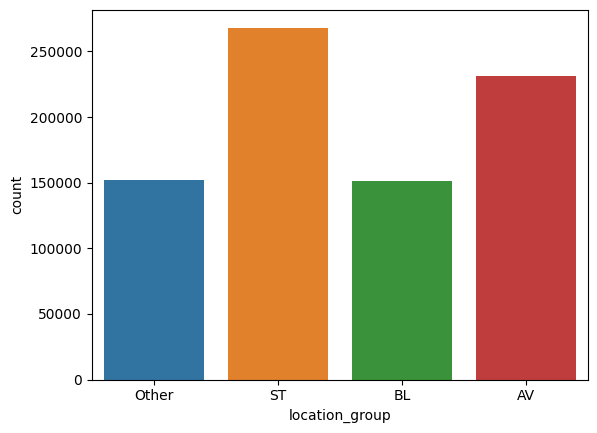

In [17]:
data['location_group'] = 'Other'  # Default to 'Other'

# Update the 'location_group' based on the specified location types
interested_location_types = ['ST', 'BL', 'AV']

# Collecting the location type
data['location_type'] = data['location'].apply(lambda x: x.split(' ')[-1])

# Use a lambda function to check if the location type is in the interested types
data['location_group'] = data['location_type'].apply(lambda x: x if x in interested_location_types else 'Other')

# Plotting the count of each location group
sns.countplot(data=data, x="location_group")
plt.show()


In [18]:
# Assuming 'date occ' is the column containing the date and time information
data['date occ'] = pd.to_datetime(data['date occ'])

# Extract day of the week, hour of the day, month, and year
data['day'] = data['date occ'].dt.day_name()
data['month'] = data['date occ'].dt.month_name()

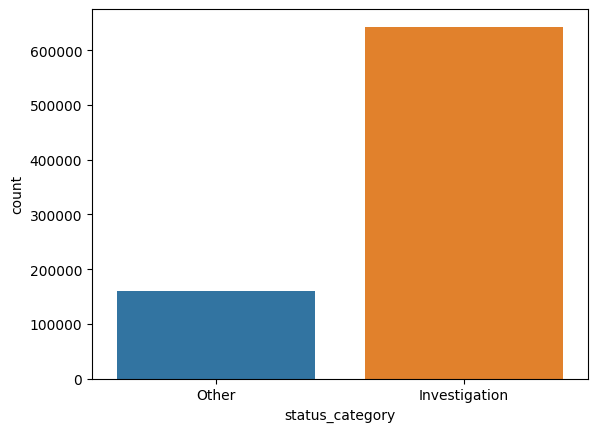

In [19]:
data['status_category'] = data['status desc'].apply(lambda x: 'Investigation' if x == 'Invest Cont' else 'Other')

# Display the result
sns.countplot(data =data, x = "status_category")
plt.show()


In [20]:
# Function to categorize crime descriptions
def categorize_crime(description):
    if 'BATTERY' in description or 'ASSAULT' in description:
        return 'Assault'
    elif 'VANDALISM' in description:
        return 'Vandalism'
    elif 'THEFT' in description or 'BURGLARY' in description:
        return 'Theft/Burglary'
    else:
        return 'Other'

# Apply the function to create a new column 'crime_category'
data['crime_category'] = data['crm cd desc'].apply(categorize_crime)

# Display unique values in the new 'crime_category' column
print(data['crime_category'].unique())


['Assault' 'Other' 'Vandalism' 'Theft/Burglary']


In [21]:
# columns to drop
drop_cols = ['dr_no', 'cross street', 'date rptd', 'date occ', 'time occ', 'area', 'area name',
       'rpt dist no', 'part 1-2', 'crm cd', 'crm cd desc', 'mocodes',
       'vict age', 'vict descent', 'premis cd', 'premis desc',
       'weapon used cd', 'weapon desc', 'status', 'status desc', 'crm cd 1',
       'crm cd 2', 'crm cd 3', 'crm cd 4', 'location', 'location_type']

df = data.drop(drop_cols, axis = 1)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802956 entries, 0 to 802955
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   vict sex          802956 non-null  int32  
 1   lat               802956 non-null  float64
 2   lon               802956 non-null  float64
 3   modified_descent  802956 non-null  int32  
 4   has_victim        802956 non-null  int64  
 5   age_bins          802956 non-null  int32  
 6   weapon_group      802956 non-null  int32  
 7   location_group    802956 non-null  object 
 8   day               802956 non-null  object 
 9   month             802956 non-null  object 
 10  status_category   802956 non-null  object 
 11  crime_category    802956 non-null  object 
dtypes: float64(2), int32(4), int64(1), object(5)
memory usage: 61.3+ MB


In [23]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your DataFrame
cat = ['location_group', 'day', 'month', 'status_category']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in cat:
    df[col] = label_encoder.fit_transform(df[col])

# Display the updated DataFrame
df[cat]


,location_group,day,month,status_category
0,2,6,4,1
1,3,6,4,0
2,3,4,3,1
3,2,6,4,0
4,3,6,4,0
...,...,...,...,...
802951,3,4,4,0
802952,3,6,7,0
802953,0,6,0,0
802954,3,2,5,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802956 entries, 0 to 802955
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   vict sex          802956 non-null  int32  
 1   lat               802956 non-null  float64
 2   lon               802956 non-null  float64
 3   modified_descent  802956 non-null  int32  
 4   has_victim        802956 non-null  int64  
 5   age_bins          802956 non-null  int32  
 6   weapon_group      802956 non-null  int32  
 7   location_group    802956 non-null  int32  
 8   day               802956 non-null  int32  
 9   month             802956 non-null  int32  
 10  status_category   802956 non-null  int32  
 11  crime_category    802956 non-null  object 
dtypes: float64(2), int32(8), int64(1), object(1)
memory usage: 49.0+ MB


# Training the data with a sample of the entire data

In [25]:
sample_size = 10000
sampled_df = df.sample(n=sample_size, random_state=42)

# removing the sampled data from the df dataset so it won't be picked for validation again
sampled_indices = sampled_df.index
df_without_sample = df.drop(sampled_indices, axis=0)


In [26]:
X = sampled_df.drop(['crime_category'], axis = 1)
y = sampled_df['crime_category']

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=23)

# Fit the model on the sampled data
rf_classifier.fit(X, y)

# Use 2000 random samples from the original data for evaluation
random_samples = df.sample(n=2000, random_state=45)
X_eval = random_samples.drop(['crime_category'], axis=1)
y_eval = random_samples['crime_category']

# Predict using the trained model
y_eval_pred = rf_classifier.predict(X_eval)

# Evaluate the model on the 200 random samples
accuracy_eval = accuracy_score(y_eval, y_eval_pred)
print(f'Model Accuracy on 2000 Random Samples: {accuracy_eval:.2%}')


Model Accuracy on 2000 Random Samples: 73.05%


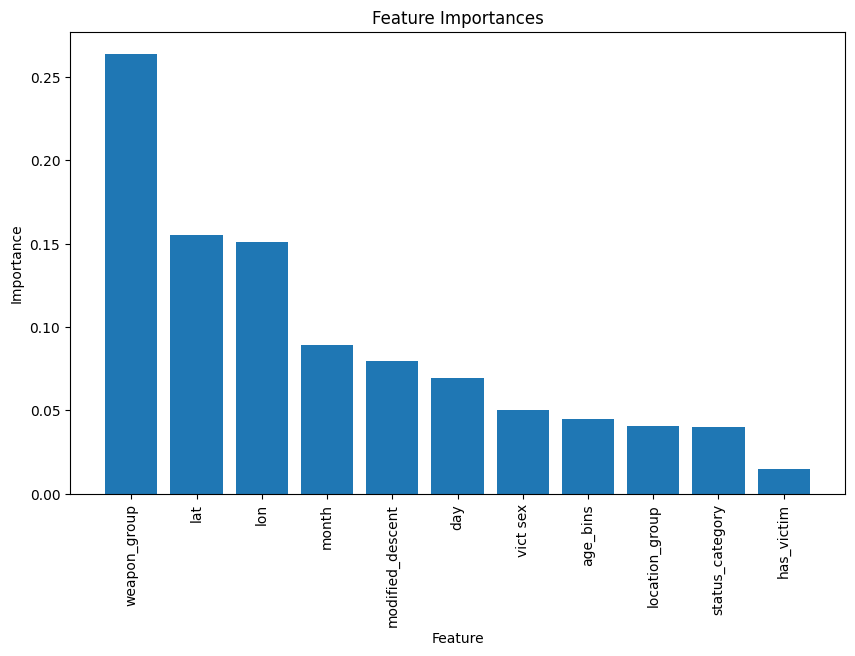

In [28]:
feature_importances = rf_classifier.feature_importances_

# Sort indices by importance
indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [30]:
import pickle

# Save the model to a file using pickle
with open('random_forest_model.pkl', 'wb') as file:
   pickle.dump(rf_classifier, file)
